# Лабораторная работа № 4

## Создание рекомендательной модели

### Цель лабораторной работы: 
<b>изучение разработки рекомендательных моделей.</b>

### Требования к отчету:
- титульный лист;
- описание задания;
- текст программы;
- экранные формы с примерами выполнения программы.

### Задание:
- Выбрать произвольный набор данных (датасет), предназначенный для построения рекомендательных моделей.
- Опираясь на материалы лекции, сформировать рекомендации для одного пользователя (объекта) двумя произвольными способами.
- Сравнить полученные рекомендации (если это возможно, то с применением метрик).

## Датасет

[ссылка](https://grouplens.org/datasets/movielens/100k/)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


## Считываем данные

### О пользователях

In [ ]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols) 
users

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


### Об оценках пользователей по фильмам (рейтингах)

In [ ]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols)
ratings.drop( "unix_timestamp", inplace = True, axis = 1) 
ratings

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


### О фильмах

In [ ]:
def clean_title(title):
    return re.sub(r"[^a-zA-Z0-9 ]", "",title)

def genre(series):
    genres = series.index[6:-2]
    
    text = []
    for i in genres:
        if series[i] == 1:
            text.append(i)
            break
    return ", ".join(text)

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
genre_cols = ['unknown', 'Action', 'Adventure', 'Animation','Childrens', 'Comedy', 'Crime',
              'Documentary', 'Drama', 'Fantasy','Film-Noir','Horror', 'Musical', 'Mystery', 
              'Romance','Sci-Fi','Thriller' , 'War' , 'Western' ]
 
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols+genre_cols,
                     encoding='latin-1')

movies['title'] = movies['title'].str.strip()
movies['title'] = movies['title'].apply(clean_title)
movies['release_year'] = movies.release_date.apply(lambda x: int(x.split('-')[2]) if isinstance(x, str) else -1)
movies.drop(columns=['video_release_date', 'imdb_url', 'release_date'], inplace=True)

movies = movies[movies.unknown != 1]
movies.drop(columns=['unknown'], inplace=True)
movies.reset_index(drop=True, inplace=True)
movies

,movie_id,title,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,1,Toy Story 1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye 1995,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms 1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty 1995,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat 1995,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,1678,Mat i syn 1997,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1998
1676,1679,B Monkey 1998,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1998
1677,1680,Sliding Doors 1998,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1998
1678,1681,You So Crazy 1994,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1994


## Готовим данные

In [ ]:
from sklearn.preprocessing import RobustScaler

movie_ranking = []
for movie_id in movies.movie_id:
  sum_rank = 0
  count_rank = 0
  for rank, movie in zip(ratings.rating, ratings.movie_id):
    if movie == movie_id:
      sum_rank += rank
      count_rank += 1
  movie_ranking.append(sum_rank/count_rank)

In [ ]:
scaler = RobustScaler()
movies['mean_rank'] = scaler.fit_transform(np.array(movie_ranking).reshape(-1, 1))

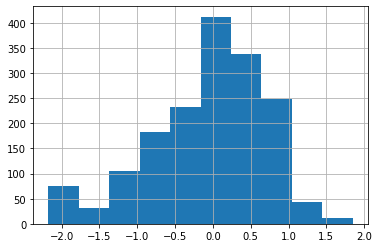

In [ ]:
movies.mean_rank.hist()

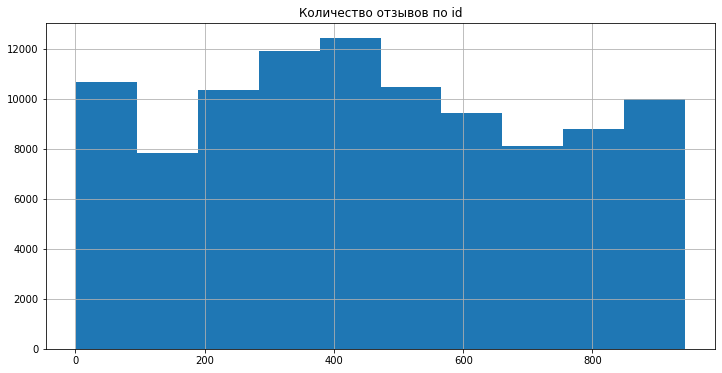

In [ ]:
plt.figure(figsize=(12, 6))
ratings.user_id.hist()
plt.title('Количество отзывов по id')
plt.show()

## Фильтрация на основе содержания

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

class SimpleKNNRecommender:
    def __init__(self, X_matrix, X_ids, X_title, X_rank):
        """
        Входные параметры:
        X_matrix - обучающая выборка (матрица объект-признак)
        X_ids - массив идентификаторов объектов
        X_title - массив названий объектов
        X_rank - массив среднего рейтинга фильмов
        """
        #Сохраняем параметры в переменных объекта
        self._X_matrix = X_matrix
        self.df = pd.DataFrame(
            {'movie_id': pd.Series(X_ids, dtype='int'),
            'title': pd.Series(X_title, dtype='str'),
            'cos_sim': pd.Series([], dtype='float'),
             'mean_rank': pd.Series(X_rank, dtype='float')})
            
            
    def recommend_for_single_object(self, K: int, \
                X_matrix_object, search_movie_id):
        """
        Метод формирования рекомендаций для одного объекта.
        Входные параметры:
        K - количество рекомендуемых соседей 
        X_matrix_object - строка матрицы объект-признак, соответствующая объекту
        search_movie_id - id фильмов
        Возвращаемое значение: K найденных соседей
        """
        
        scale = 100000
        # Вычисляем косинусную близость по матрице жанров
    
        dist = cosine_similarity(self._X_matrix, X_matrix_object)
        self.df['cos_sim'] = (dist * scale).round(2)
        res = self.df
        
        res = res[(res.cos_sim <= scale) & (res.movie_id != search_movie_id)]

        res.drop_duplicates(subset=['movie_id'], inplace=True) # сбрасываем дубликаты если они есть
        res = res.sort_values(by=['cos_sim', 'mean_rank'], ascending=[False, False])

        # Оставляем К первых рекомендаций
        return res.head(K)

In [ ]:
test_movie = movies.iloc[4]
test_movie

movie_matrix = movies.iloc[:, 2:-1]

movie_id                   5
title           Copycat 1995
Action                     0
Adventure                  0
Animation                  0
Childrens                  0
Comedy                     0
Crime                      1
Documentary                0
Drama                      1
Fantasy                    0
Film-Noir                  0
Horror                     0
Musical                    0
Mystery                    0
Romance                    0
Sci-Fi                     0
Thriller                   1
War                        0
Western                    0
release_year            1995
mean_rank           0.141662
Name: 4, dtype: object

In [ ]:
recommender = SimpleKNNRecommender(movie_matrix, movies.movie_id,
                                   movies.title, movies.mean_rank)

rec1 = recommender.recommend_for_single_object(K=5,
                                               X_matrix_object=movie_matrix[test_movie.movie_id].reshape(1,-1),
                                               search_movie_id = test_movie.movie_id,)

print('Searching same as:', movies[movies.movie_id == test_movie.movie_id].title.iloc[0])

rec1.drop_duplicates(subset=['movie_id'], inplace=True)
rec1[['movie_id', 'title', 'cos_sim', 'mean_rank']]

rec1.join(movies[[i for i in movies.columns if i !='title' and i != 'mean_rank']], lsuffix='l_')

Searching same as: Copycat 1995


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,movie_idl_,title,cos_sim,mean_rank,movie_id,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
1393,1396,Stonewall 1995,100000.0,1.044843,1396,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1996
921,923,Raise the Red Lantern 1991,100000.0,0.999741,923,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1991
135,136,Mr Smith Goes to Washington 1939,100000.0,0.968185,136,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1939
494,496,Its a Wonderful Life 1946,100000.0,0.965572,496,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1946
165,166,Manon of the Spring Manon des sources 1986,100000.0,0.965046,166,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1986


## Коллаборативная фильтрация

### Готовим даныне о пользователях

In [ ]:
users

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [ ]:
top_1_arr = []

for user in users.user_id:
  top_1 = None
  max_1 = 0
  
  for u_id, m_id, rating in zip(ratings.user_id, ratings.movie_id, ratings.rating):
    if u_id == user:
      if rating > max_1:
        max_1 = rating
        top_1 = m_id

  top_1_arr.append(top_1)

users['movie_id'] = top_1_arr

In [ ]:
users = users.merge(movies[['movie_id', 'mean_rank']])

In [ ]:
users['sex'] = users.sex.apply(lambda x: 1 if x == 'M' else 0)

In [ ]:
from sklearn.preprocessing import LabelEncoder

print('count of different occupations', len(users['occupation'].unique()))
occ_enc = LabelEncoder()
users['occupation'] = occ_enc.fit_transform(users.occupation)

count of different occupations 21


In [ ]:
def zip_code_processing(code):
  if code.isdigit():
    return int(code)
  else:
    return np.NaN

users['zip_code'] = users.zip_code.apply(zip_code_processing)

In [ ]:
users.zip_code.fillna(value=users.zip_code.mode()[0], inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler_mm = MinMaxScaler()
users_matrix = scaler_mm.fit_transform(users)
users_matrix.shape

(943, 7)

### Делаем рекоммендацию

In [ ]:
TEST_USER_INDEX = 400

test_user = users.iloc[TEST_USER_INDEX]
test_user_id = users.iloc[TEST_USER_INDEX].user_id
# test_user_titles = list(set(df_not_encoded[df_not_encoded.user_id == test_user_id].title))
print('test_user_id', test_user_id, '\n', test_user)


test_user_matrix = np.array(test_user).reshape(1, -1)
print(test_user_matrix.shape)

rec = users.copy()

rec['similarity'] = cosine_similarity(users_matrix, test_user_matrix)

test_user_id 691.0 
 user_id         691.000000
age              34.000000
sex               0.000000
occupation        3.000000
zip_code      60089.000000
movie_id        603.000000
mean_rank         1.233554
Name: 400, dtype: float64
(1, 7)


In [ ]:
rec = rec[rec.user_id != TEST_USER_INDEX]
rec = rec.sort_values(by=['similarity'], ascending=False).reset_index(drop=True)


def get_seen_test_movies(ratings_df, movies_df, user_index):
  ratings_df = ratings_df[ratings_df.user_id == user_index].merge(movies_df)  
  return list(ratings_df.iloc[:, 3])


result_rec = rec.head(5).merge(movies[['movie_id','title']] )

seen_movies = get_seen_test_movies(ratings, movies, TEST_USER_INDEX)
seen_movies

flag = 0
for i in result_rec.iloc[:, -1]:
  if i not in seen_movies:
    flag = 1
    print(i)
    break

if flag == 0:
  print('Выберите больше похожих пользователей чтобы получить рекоммендуемый фильм, который вы еще не смотрели')

Ace Ventura Pet Detective 1994
